In [2]:
# 指定CPU跑
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [28]:
import numpy as np
np.__version__

'1.16.4'

In [1]:
import tensorflow as tf
import numpy as np
rng = np.random

# 使用TensorFlow通过回归验证通用近似定理
***
神经网络中，我们把神经元看作网络节点，在节点处通常是使用一个非线性函数$\sigma()$去作用到输入信号上面。~~而在不同层之间的神经元之间会相互连接.~~ 而第n层神经元与第n+1层神经元连接（单向），而这种连接在神经网络中以权重w进行表示。  
那么**信号由第n层到第n+1层中的第i个神经元**，便可以表示成如下(其中m表示此批次的样本数)：
$$
x_i^{(n+1)} = \sigma(\sum_m{w^{(n)}_m x^{(n)}_m + b^{(n)}})
$$
从上面的公式也可以看出，n+1层的神经元通常会与上一层的每个神经元存在联系（全连接时），而在单层神经元之间彼此通常是没有直接连接的。那么如果我们能证明这一层的神经元之间是相互正交的，那么我们就证明了这一层神经元可以拟合得到任意函数。  
证明：  

pass

## 自定义模型实现：

### 批操作生成函数

对输入数据应保持形状为(m,num_feature)， 这样输入神经网络后便可以以矩阵相乘的形式得到最后为(m, num_class)的结果，即  
(m, num_feature)* (num_feature, hidden1)* (hidden1, hidden2)* ... * (hiddenN, num_classis)

In [2]:
tf.test.is_gpu_available()

True

In [2]:
# 批操作
x_data = np.linspace(0,10,100)

def genData(x_data,batch_size=100):
    L = len(x_data)
    idx = np.arange(0,L)
    count=0
    while True: # 让其一轮结束后开始新一轮
#         count += 1
        np.random.shuffle(idx)
        batchs = L//batch_size
        for i in range(batchs):
#             print(count)
            x = x_data[idx][i*batch_size:(i+1)*batch_size].reshape(batch_size,-1)
            yield x,tf.constant(np.sin(x))

In [3]:
g = genData(x_data)

In [4]:
X,Y = next(g) 
X.shape,Y.shape

((100, 1), TensorShape([100, 1]))

In [5]:

# Y = np.square(X)

print(Y.shape)
print(X.shape)

(100, 1)
(100, 1)


In [6]:
X.shape

(100, 1)

In [7]:
# tf.Variable(rng.randn(50,3))@tf.Variable(rng.randn(3,3))+ tf.Variable(rng.randn(50,3))
a = rng.randn(5,3,3)
print('第0，1维度\n',a[:,:,1]) # 返回 5*3
print('第1，2维度\n',a[1,:,:]) # 返回3*3
print('第0，2维度\n',a[:,1,:]) # 5*3

第0，1维度
 [[-0.46156968 -0.38617585  0.02612892]
 [ 1.29932291 -0.22075114 -1.37407067]
 [ 0.32501346 -0.07029827 -0.40819744]
 [ 0.05007202 -0.49081395 -0.78309403]
 [-1.46938048  1.41040868  0.37193681]]
第1，2维度
 [[-1.75709161  1.29932291 -1.05641929]
 [-0.81077518 -0.22075114  2.14160903]
 [ 1.13261512 -1.37407067  0.53375016]]
第0，2维度
 [[-1.2439628  -0.38617585 -1.25766687]
 [-0.81077518 -0.22075114  2.14160903]
 [-0.11821836 -0.07029827  0.50179183]
 [ 0.06718565 -0.49081395 -0.93250218]
 [-0.33880966  1.41040868 -0.50949529]]


In [8]:
rng.randn(5,3)

array([[-0.33080786,  1.46880034, -0.57774505],
       [ 1.63946408,  0.18678567,  1.87831592],
       [-0.39426823,  0.02738337,  2.64734079],
       [ 0.81100893, -0.42243035, -2.03840511],
       [ 0.45872657,  0.31576853, -1.00427967]])

In [9]:
class Model:
    def __init__(self, input_shape=[50,1],num_layers = 2):
        '''input_shape = [batch_size, feature_size]'''
       
        self.batch_size, self.num_feature = input_shape[0], input_shape[1]
        self.num_layers = num_layers

        hidden1, hidden2 = 100,100 # 单个隐藏层神经元个数
        out_put = 1
        self.w0 = tf.Variable(rng.randn(self.num_feature, hidden1), name = 'weight0')
        self.b0 = tf.Variable(rng.randn(self.batch_size, hidden1), name = 'bias0')
        
        self.w1 = tf.Variable(rng.randn(hidden1, hidden2, num_layers), name = 'weight1')
        self.b1 = tf.Variable(rng.randn(self.batch_size, hidden2, num_layers), name = 'bias1')
        
        self.w2 = tf.Variable(rng.randn(hidden2, out_put), name = 'weight2')
        self.b2 = tf.Variable(rng.randn(self.batch_size, out_put), name = 'bias2')
        
        self.wp = tf.Variable(rng.randn(out_put, out_put), name = 'weight_predict')
        self.bp = tf.Variable(rng.randn(self.batch_size, out_put), name = 'weight_predict')
        


    def __call__(self,X):
        
#         out = tf.nn.sigmoid(X@ self.w0 + self.b0) # 输入层
        out = tf.nn.sigmoid(tf.multiply(X, self.w0)+ self.b0) # 输入层
        for i in range(self.num_layers):
             out = tf.nn.sigmoid(out @ self.w1[:,:,i] + self.b1[:,:,i])# 隐藏层
    
        out = tf.nn.sigmoid(out@self.w2+self.b2)# 输出层的前一层
        out = out @ self.wp + self.bp # 输出层(预测层)
        return out
        
def lossfunc(OUT,Y):
    return tf.reduce_mean(tf.square(OUT-Y)) 

model = Model(input_shape=[100,1], num_layers=1)
pred = model(X)
# print(pred)
loss = lossfunc(pred,Y)
loss

<tf.Tensor: id=89, shape=(), dtype=float64, numpy=1.4319681110850533>

In [10]:
# Stochastic Gradient Descent Optimizer.
learning_rate = 1
# optimizer = tf.optimizers.Adadelta(learning_rate)
optimizer = tf.optimizers.Adadelta(learning_rate)

In [11]:
# Optimization process. 
def run_optimization():
    # 将导数的计算封装在 GradientTape 中
    with tf.GradientTape() as g:
        loss = lossfunc(model(X),Y)
        
    # 计算loss对W和b的导数：
    gradients = g.gradient(loss, [model.w0, model.b0,model.w1, model.b1,model.w2, model.b2, model.wp, model.bp])
    # 根据梯度更新W,b
    optimizer.apply_gradients(zip(gradients,[model.w0, model.b0,model.w1, model.b1,model.w2, model.b2, model.wp, model.bp]))

In [14]:
# Run training for the given number of steps.
training_steps = 1000
display_step=100

writer = tf.summary.create_file_writer("./mylogs")
with writer.as_default(): # 这是为了后面的tf.summary.scalar()
    for step in range(1, training_steps + 1):
        X,Y = next(genData(x_data))

        # Run the optimization to update W and b values.
        run_optimization()

        tf.summary.scalar('loss',loss, step=step)
        writer.flush()
        if step % display_step == 0:
            pred = model(X)
            loss = lossfunc(pred,Y)
            print("step: {}, loss: {}".format(step, loss))


step: 100, loss: 0.306129454708784
step: 200, loss: 0.2609610680851435
step: 300, loss: 0.2712667273082127
step: 400, loss: 0.20745436860377298
step: 500, loss: 0.2164233143520166
step: 600, loss: 0.18715962492142166
step: 700, loss: 0.15119821589828547
step: 800, loss: 0.16999068044360402
step: 900, loss: 0.1973691871379388
step: 1000, loss: 0.15589553711896403


tensorboard --logdir=C:\Users\beidongjiedeguang\OneDrive\a_github\tensorflow从0开始\mylogs  
赋值上面命令到命令行  

http://localhost:6006/#scalars

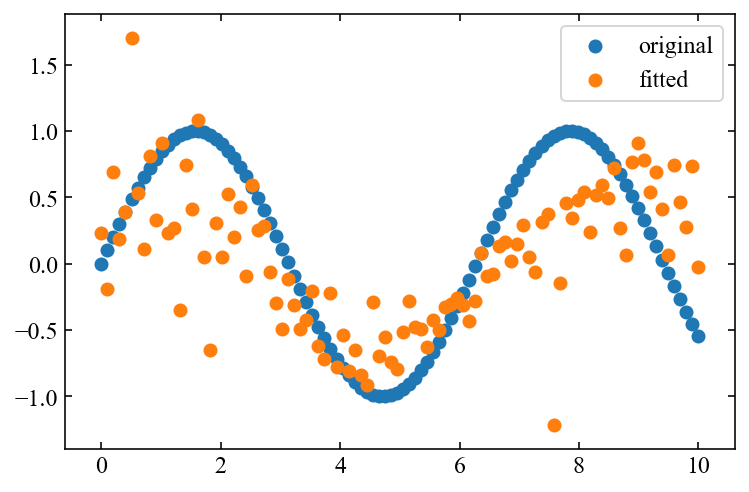

In [13]:
import matplotlib.pyplot as plt
# Graphic display
plt.scatter(X, Y,label='original')
plt.scatter(X.reshape(1,-1), model(X).numpy().reshape(1,-1),label='fitted')
plt.legend()
plt.show()

In [14]:
model.w

<tf.Variable 'weight:0' shape=(3, 1) dtype=float64, numpy=
array([[-0.10421957],
       [ 0.34857553],
       [-1.63328154]])>

In [15]:
model.b

<tf.Variable 'bias:0' shape=(3, 1) dtype=float64, numpy=
array([[-0.49231938],
       [ 0.24034195],
       [ 1.21735975]])>

In [103]:
print(X.shape)
X.sort(axis = 0)
print(X.shape)
print(model(X).shape)


(50, 1)
(50, 1)
(50, 1)


In [ ]:
test_x = np.linspace(0,2*np.pi,50)
test_x= np.reshape(test_x,[50,1])
plt.scatter(test_x,model(test_x).numpy(),c='y',marker= 'o')
plt.scatter(test_x,(np.sin(test_x)+1)/2, c='b', marker= '*')

## 使用tf.keras API实现

In [398]:

from tensorflow.keras import Input,Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten,Dense,Dropout,Conv2D

In [ ]:
def GenerateData(datasize = 100):
    trainX = np.linspace(-1, 1, datasize)
    trainY = 2* trainX + rng.randn()

In [368]:
def GenerateData(datasize = 100 ):
    train_X = np.linspace(-1, 1, datasize)   #train_X为-1到1之间连续的100个浮点数
    train_Y = 2 * train_X + np.random.randn(*train_X.shape) * 0.3 # y=2x，但是加入了噪声
    yield train_X, train_Y   #以生成器的方式返回

In [372]:
train_data = next(GenerateData())

In [385]:
inputs = tf.keras.Input(shape=(1,))
dense = tf.keras.layers.Dense(1)
outputs = dense(inputs)
print(inputs)
print(dense)
print(outputs)

In [ ]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [376]:
x = tf.keras.Input(shape=(32,10))# 这里shape给出的是input的特征形状，得到的x的shape其实=[batch,shape]
y = tf.square(x)

In [377]:
x

<tf.Tensor 'input_2:0' shape=(None, 32, 10) dtype=float32>